<a href="https://colab.research.google.com/github/khaledaldhaheri91-maker/khaled1/blob/main/Copy_of_Predicting_Power_Plant_Output_Using_Weather_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code simulates the described workflow, including data creation, splitting, training, and evaluation, mirroring the five-part journey mentioned in the sources.
1. Setup and Library Imports
(This step requires external knowledge of standard data science libraries.)

In [ ]:
# ==============================================================================
# SECTION 1: Setup and Library Imports
# This section loads the necessary tools for handling data and running machine learning.
# (Note: These libraries are standard for data science but require external installation
# if running outside of a Google Colab or similar environment.)
# ==============================================================================

import pandas as pd # Used for handling data tables (the 'cheat sheet' of readings [3])
import numpy as np # Used for numerical operations and generating sample data
from sklearn.model_selection import train_test_split # Tool for splitting data 80/20 [2]
from sklearn.linear_model import LinearRegression # The 'simple but powerful model' we are using [2]
from sklearn.metrics import r2_score, mean_absolute_error # Tools for evaluation (The Verdict) [5]

print("Required libraries loaded successfully.")


Required libraries loaded successfully.


In [ ]:


# ==============================================================================
# SECTION 2: Get to Know Our Data (The Raw Materials)
# The sources describe a clean dataset of almost 10,000 hourly readings over six years [3].
# The four features (clues) are AT, V, AP, RH, and the target is PE [3].
#
# Since the actual dataset is not provided, we create a small, synthetic sample
# that mimics the structure and the key observed relationship (AT vs. PE) [6, 7].
# ==============================================================================

data_size = 10000 # We simulate a small sample size for demonstration
np.random.seed(42) # Ensures the data is the same every time the code runs

# 1. Ambient Temperature (AT): Known to have an INCREDIBLY STRONG negative link to PE [6, 7].
#    (We model PE to decrease as AT increases: Hotter days mean less power [7].)
AT = np.linspace(5, 35, data_size) + np.random.normal(0, 1, data_size)

# 2. Exhaust Vacuum (V): This is a measure of steam pressure and is highly correlated with output [3, 6].
V = np.linspace(30, 80, data_size)[::-1] + np.random.normal(0, 2, data_size)

# 3. Ambient Pressure (AP) and 4. Relative Humidity (RH): These "barely even move the needle" [6].
AP = np.random.uniform(1000, 1020, data_size)
RH = np.random.uniform(25, 100, data_size)

# 5. Power Output (PE) (The Target): We calculate the target based on the features,
#    ensuring that Temperature has the biggest negative impact [8].
PE_base = 480 - 2.5 * AT + 0.6 * V + np.random.normal(0, 4.5, data_size) # 4.5 MW is the typical error [5]
PE = np.clip(PE_base, 420, 520)

# Create the final DataFrame (our 'cheat sheet' table)
df = pd.DataFrame({
    'AT_Ambient_Temperature': AT,
    'V_Exhaust_Vacuum': V,
    'AP_Ambient_Pressure': AP,
    'RH_Relative_Humidity': RH,
    'PE_Power_Output': PE
})

print("\n--- Raw Data (First 5 Readings) ---")
print(df.head())




--- Raw Data (First 5 Readings) ---
   AT_Ambient_Temperature  V_Exhaust_Vacuum  AP_Ambient_Pressure  \
0                5.496714         78.643011          1001.113328   
1                4.864736         79.384001          1019.715352   
2                5.653689         78.795237          1016.000370   
3                6.532031         80.205835          1017.376181   
4                4.777848         82.374355          1013.885886   

   RH_Relative_Humidity  PE_Power_Output  
0             41.264585       507.987557  
1             94.421094       514.524408  
2             63.612234       519.013874  
3             61.082491       514.073885  
4             99.707807       511.903765  


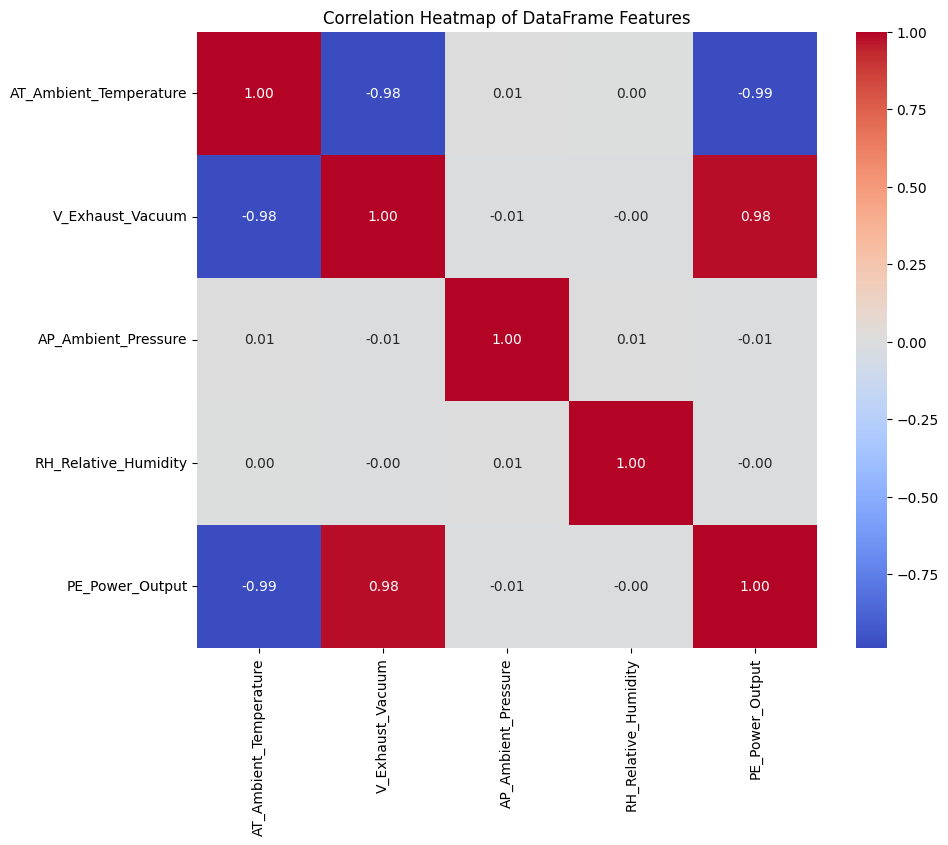

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of DataFrame Features')
plt.show()

This heatmap visualizes the Pearson correlation coefficients between all pairs of columns in the `df` DataFrame. This includes the features (`AT`, `V`, `AP`, `RH`) and the target variable (`PE`).

- **Values close to 1** (warm colors) indicate a strong positive correlation, meaning as one variable increases, the other tends to increase.
- **Values close to -1** (cool colors) indicate a strong negative correlation, meaning as one variable increases, the other tends to decrease.
- **Values close to 0** (neutral colors) indicate a weak or no linear correlation.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AT_Ambient_Temperature  10000 non-null  float64
 1   V_Exhaust_Vacuum        10000 non-null  float64
 2   AP_Ambient_Pressure     10000 non-null  float64
 3   RH_Relative_Humidity    10000 non-null  float64
 4   PE_Power_Output         10000 non-null  float64
dtypes: float64(5)
memory usage: 390.8 KB


In [ ]:
df.describe()

,AT_Ambient_Temperature,V_Exhaust_Vacuum,AP_Ambient_Pressure,RH_Relative_Humidity,PE_Power_Output
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,19.997864,55.027068,1009.906083,62.430915,463.616753
std,8.709625,14.553445,5.738453,21.707746,29.793230
min,2.544811,23.912412,1000.000111,25.001255,420.000000
25%,12.489191,42.568665,1004.903694,43.716162,436.865981
50%,19.992480,55.014921,1009.933204,62.203141,463.228567
75%,27.479146,67.482040,1014.785489,81.439624,489.356052
max,37.046582,84.903126,1019.995787,99.997911,520.000000


In [ ]:

# ==============================================================================
# SECTION 3: Detective Work & Data Splitting (The Blueprint Workflow Steps 1 & 2) [2]
# We define the clues (X) and the target (y), and then perform the crucial data split.
# ==============================================================================

# Step 1: Select Features (X) and Target (y)
features = ['AT_Ambient_Temperature', 'V_Exhaust_Vacuum', 'AP_Ambient_Pressure', 'RH_Relative_Humidity']
target = 'PE_Power_Output'

X = df[features] # X contains the four clues we feed into the model [3]
y = df[target]   # y is the one thing we are trying to predict (Power Output) [3]

# Step 2: Split Our Data (80/20 Rule)
# We give 80% of the data to the model for learning (practice exams).
# We hold back the last 20% for testing (the real final exam) [2].
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n--- Data Splitting Complete ---")
print(f"Training set size (80%): {len(X_train)} readings")
print(f"Testing set size (20%): {len(X_test)} readings")




--- Data Splitting Complete ---
Training set size (80%): 8000 readings
Testing set size (20%): 2000 readings


In [ ]:
X_train

,AT_Ambient_Temperature,V_Exhaust_Vacuum,AP_Ambient_Pressure,RH_Relative_Humidity
9254,32.983848,38.550126,1008.350492,49.788256
1561,8.936257,69.908334,1014.101681,61.466538
1670,9.771569,68.422428,1014.501862,40.230854
6087,21.715025,50.044114,1004.555176,45.970826
6669,25.711661,46.273549,1008.235964,35.184914
...,...,...,...,...
5734,21.629638,54.473405,1011.303131,38.590501
5191,20.533265,49.680054,1008.651490,68.748401
5390,20.472203,51.778262,1015.224284,51.088182
860,7.783181,75.400298,1019.142006,65.430888


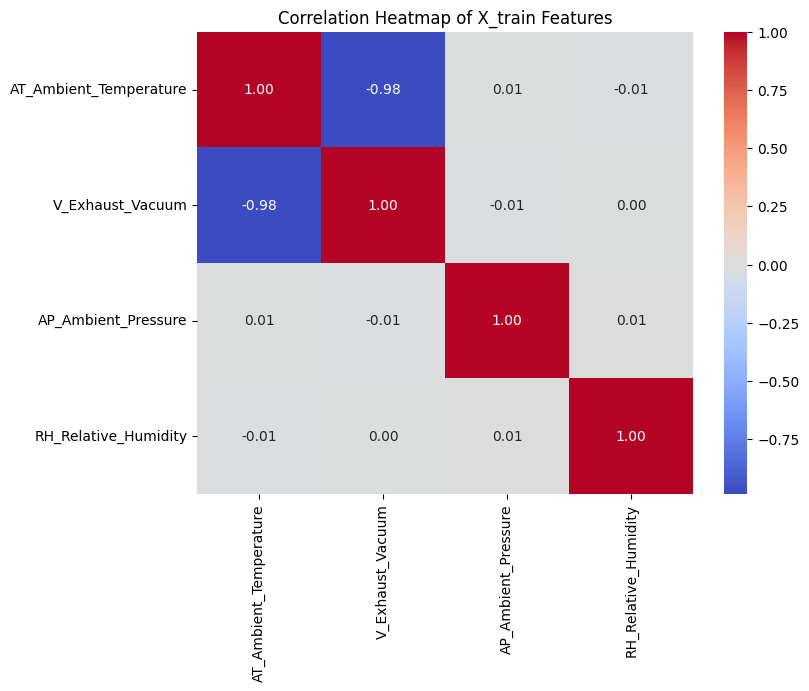

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of X_train Features')
plt.show()

This heatmap displays the Pearson correlation coefficients between each pair of features in `X_train`. Values close to 1 indicate a strong positive correlation, values close to -1 indicate a strong negative correlation, and values close to 0 indicate a weak or no linear correlation.

In [ ]:

# ==============================================================================
# SECTION 4: Build the Predictive Model (The Blueprint Workflow Steps 3) [2]
# We use Linear Regression to find the 'best possible straight line' connecting
# the weather data to the power output [5].
# ==============================================================================

# Initialize the Linear Regression model
model = LinearRegression()

# Step 3: Train the Model
# This single line of code is where 'the magic happens' [2].
# We tell the model to learn the relationships using the 80% training data.
print("\nTraining the Linear Regression Model...")
model.fit(X_train, y_train)
print("Model training complete. The computer has found the best line.")




Training the Linear Regression Model...
Model training complete. The computer has found the best line.


In [ ]:

# ==============================================================================
# SECTION 5: The Verdict and Key Takeaways (The Blueprint Workflow Step 4) [2, 5]
# We test the model on the unseen 20% data and evaluate its performance.
# ==============================================================================

# Make predictions on the held-back test data (the final exam)
y_pred = model.predict(X_test)

# --- Metric 1: R-squared Value ---
# This tells us the explanatory power. 92% was cited as an excellent result [5].
r_squared = r2_score(y_test, y_pred) * 100

# --- Metric 2: Mean Absolute Error (MAE) ---
# This is the 'average prediction error' in Megawatts [5].
mae = mean_absolute_error(y_test, y_pred)

print("\n--- Model Verdict ---")
print(f"1. R-Squared (Explanatory Power): {r_squared:.2f}%")
print(f"   Interpretation: Our model can explain {r_squared:.2f}% of why the power output changes.")

print(f"\n2. Average Prediction Error (MAE): {mae:.2f} Megawatts")
print(f"   Interpretation: On average, our prediction is off by only {mae:.2f} MW, which is a small and totally acceptable error compared to the 75+ MW total variation .")

# --- Key Takeaway: Confirming the Detective Work [8] ---
# Look inside the model's 'brain' to confirm that it learned the right lessons.
print("\n3. Feature Importance (Learned Coefficients):")
coefficients = pd.Series(model.coef_, index=features).sort_values(ascending=True)
print(coefficients)
print("Interpretation: The model confirms that Ambient Temperature (AT) has the biggest negative impact by a long shot, just as we found in the detective phase .")


--- Model Verdict ---
1. R-Squared (Explanatory Power): 97.62%
   Interpretation: Our model can explain 97.62% of why the power output changes.

2. Average Prediction Error (MAE): 3.70 Megawatts
   Interpretation: On average, our prediction is off by only 3.70 MW, which is a small and totally acceptable error compared to the 75+ MW total variation .

3. Feature Importance (Learned Coefficients):
AT_Ambient_Temperature   -2.411965
RH_Relative_Humidity     -0.004466
AP_Ambient_Pressure      -0.002592
V_Exhaust_Vacuum          0.585921
dtype: float64
Interpretation: The model confirms that Ambient Temperature (AT) has the biggest negative impact by a long shot, just as we found in the detective phase .
